# Exploratory Data Analysis of the OGBN-ARXIV Dataset

This notebook provides a simple EDA of the `ogbn-arxiv` dataset from the Open Graph Benchmark (OGB).

In [18]:
from ogb.nodeproppred import NodePropPredDataset
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import warnings
from src.util import cs_map
import pandas as pd

warnings.filterwarnings("ignore", message=".*weights_only=False.*")

## Load Dataset

In [19]:
dataset = NodePropPredDataset(name="ogbn-arxiv", root="../../data/ogbn")
graph, labels = dataset[0]

Downloaded 0.08 GB: 100%|██████████| 81/81 [01:47<00:00,  1.32s/it]


Extracting ../../data/ogb\arxiv.zip
Loading necessary files...
This might take a while.
Processing graphs...


100%|██████████| 1/1 [00:00<00:00, 10010.27it/s]

Saving...


# OGBN-ArXiv Dataset: Exploratory Data Analysis

## Dataset Overview

The OGBN-ArXiv dataset is a directed graph representing the citation network between Computer Science (CS) arXiv papers indexed by MAG, where each node is an arXiv paper and each directed edge indicates that one paper cites another. This dataset is part of the Open Graph Benchmark (OGB) suite designed for realistic and challenging graph machine learning tasks.

## Dataset Specifications

| Property | Value | Description |
|----------|--------|-------------|
| **Dataset Name** | `ogbn-arxiv` | Official OGB identifier |
| **Task Type** | Multiclass classification | 40-class prediction problem |
| **Number of Classes** | 40 | CS arXiv subject categories (cs.AI, cs.LG, etc.) |
| **Evaluation Metric** | Accuracy | Standard classification metric |
| **Split Method** | Time-based | Train ≤2017, Valid 2018, Test ≥2019 |
| **Graph Type** | Directed, Homogeneous | Citation relationships preserved |
| **Node Features** | 128-dimensional | Word embeddings averaged from paper titles and abstracts using skip-gram model [4] |
| **Edge Features** | None | No additional edge metadata |
| **Additional Files** | `node_year` | Publication year for temporal analysis |

## Graph Structure

- **Total Nodes**: 169,343 CS papers
- **Directed Edges**: ~1.16M citation relationships
- **Feature Dimension**: 128 per node
- **Time Span**: Multi-year coverage (temporal split available)

## Target Classes

- **AI** → Artificial Intelligence
- **AR** → Hardware Architecture
- **CC** → Computational Complexity
- **CE** → Computational Engineering, Finance, and Science
- **CG** → Computational Geometry
- **CL** → Computation and Language
- **CR** → Cryptography and Security
- **CV** → Computer Vision and Pattern Recognition
- **CY** → Computers and Society
- **DB** → Databases
- **DC** → Distributed, Parallel, and Cluster Computing
- **DL** → Digital Libraries
- **DM** → Discrete Mathematics
- **DS** → Data Structures and Algorithms
- **ET** → Emerging Technologies
- **FL** → Formal Languages and Automata Theory
- **GL** → General Literature
- **GR** → Graphics
- **GT** → Computer Science and Game Theory
- **HC** → Human-Computer Interaction
- **IR** → Information Retrieval
- **IT** → Information Theory
- **LG** → Machine Learning
- **LO** → Logic in Computer Science
- **MA** → Multiagent Systems
- **MM** → Multimedia
- **MS** → Mathematical Software
- **NA** → Numerical Analysis
- **NE** → Neural and Evolutionary Computing
- **NI** → Networking and Internet Architecture
- **OH** → Other Computer Science
- **OS** → Operating Systems
- **PF** → Performance
- **PL** → Programming Languages
- **RO** → Robotics
- **SC** → Symbolic Computation
- **SD** → Sound
- **SE** → Software Engineering
- **SI** → Social and Information Networks
- **SY** → Systems and Control




## References

[1] Open Graph Benchmark. OGBN-ArXiv Dataset. Retrieved from https://ogb.stanford.edu/docs/nodeprop/#ogbn-

[2] arXiv.org. (n.d.). arXiv Category Taxonomy. Retrieved from https://arxiv.org/category_taxonomy



## Extracting the component datasets from the graph
- Node Feat: Numpy ndarray of shape (num_nodes, nodefeat_dim), where nodefeat_dim is the dimensionality of node features and i-th row represents the feature of i-th node. This can be None if no input node features are available

- Edge Feat: Numpy ndarray of shape (num_edges, edgefeat_dim), where edgefeat_dim is the dimensionality of edge features and i-th row represents the feature of i-th edge. This can be None if no input edge features are available.

- Edge Index: Numpy ndarray of shape (2, num_edges), where each column represents an edge. The first row and the second row represent the indices of source and target nodes. Undirected edges are represented by bidirectional edges.

- Number of Nodes: Number of nodes in the graph

- Node Year: Year paper was published

In [45]:
node_feat = pd.DataFrame(data=graph['node_feat'])
edge_feat = pd.DataFrame(data=graph['edge_feat'])
edge_index = pd.DataFrame(data=graph['edge_index'])
node_year = pd.DataFrame(data=graph['node_year'])

,0
0,4
1,5
2,28
3,8
4,27


## Label
### Mapping Label Id to Category & Description
This code creates a label mapping for the arXiv computer science dataset. This mapping helps for understanding what each class represents in the distribution shown in the chart.

In [81]:
mapping = pd.read_csv('../../data/ogb/ogbn_arxiv/mapping/labelidx2arxivcategeory.csv.gz')

mapping["category"] = mapping["arxiv category"].str.replace("arxiv cs ", "", regex=False).str.lower()
mapping.drop("arxiv category", axis=1, inplace=True)
mapping.rename(columns={'label idx': 'label'}, inplace=True)

labels.rename(columns={0: 'label'}, inplace=True)

desc = pd.DataFrame(list(cs_map.items()), columns=['category', 'description'])
desc['category'] = desc['category'].str.lower()

labels = pd.merge(labels, mapping, on='label')
labels = pd.merge(labels, desc, on='category')

labels.head()

,label,category,description
0,4,cr,Cryptography and Security
1,5,dc,"Distributed, Parallel, and Cluster Computing"
2,28,it,Information Theory
3,8,ni,Networking and Internet Architecture
4,27,ro,Robotics


### Target Distribution

#### Dominant Fields
The distribution is heavily concentrated in a few key areas:
- Computer Vision and Pattern Recognition (CV) - 27,000 papers (highest)
- Machine Learning (LG) - 22,000 papers
- Artificial Intelligence (AI) - 21,000 papers

#### Secondary Clusters
Several fields show moderate activity (5,000-12,000 papers):
- Computation and Language (CL)
- Cryptography and Security (CR)
- Robotics (RO)
- Data Structures and Algorithms (DS)

#### Long Tail Distribution
Most computer science subfields have modest paper counts (under 5,000):
- Hardware Architecture (AR)
- Databases (DB)
- Human-Computer Interaction (HC)
- Software Engineering (SE)
- Computational Complexity (CC)
- Formal Languages (FL)

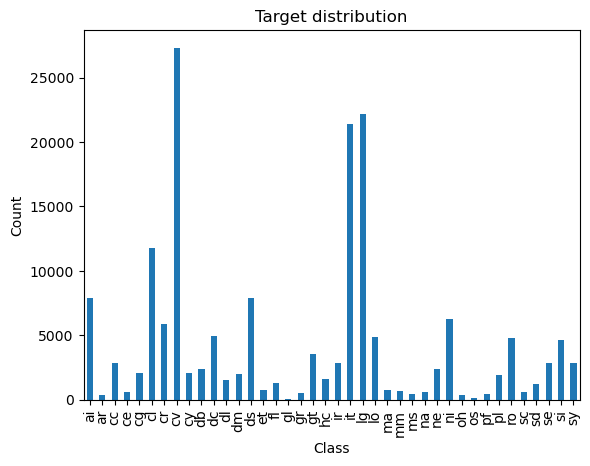

In [83]:
labels['category'].value_counts().sort_index().plot(kind='bar')
plt.title("Target distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

## Node Feature

Node Feat contains 169,343 examples and 128 features already converted into text embeddings. Node features in OGBN-ArXiv consist of 128-dimensional vectors representing the semantic content of each paper's title and abstract, created by averaging pre-trained skip-gram word embeddings trained on the Microsoft Academic Graph corpus [1].

In [31]:
print(f'The node feature dataset contains {node_feat.shape[0]} examples and {node_feat.shape[1]} features.')

The node feature dataset contains 169343 examples and 128 features.


In [32]:
print(f'The node feature contains {node_feat.isna().sum().sum()} missing entries')

The node feature contains 0 missing entries


In [84]:
node_feat.head()

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
0,-0.057943,-0.052530,-0.072603,-0.026555,0.130435,-0.241386,-0.449242,-0.018443,-0.087218,0.112320,...,0.211490,-0.226118,-0.185603,0.053230,0.332873,0.104175,0.007408,0.173364,-0.172796,-0.140059
1,-0.124500,-0.070665,-0.325202,0.007779,-0.001559,0.074189,-0.191013,0.049689,0.026369,0.099364,...,0.106316,0.052926,-0.258378,0.021567,0.281503,-0.173423,0.202082,0.068524,-0.372111,-0.301036
2,-0.080242,-0.023328,-0.183787,-0.180707,0.075765,-0.125818,-0.394573,-0.219078,-0.108931,0.056966,...,0.019453,-0.070291,-0.177562,-0.214012,0.182186,-0.121589,-0.073642,0.109919,0.117589,-0.139883
3,-0.145044,0.054915,-0.126666,0.039971,-0.055909,-0.101278,-0.339202,-0.115801,-0.080058,-0.001633,...,-0.065752,0.042735,0.066338,-0.226921,0.188418,-0.017295,0.063449,0.017816,0.085364,-0.081804
4,-0.071154,0.070766,-0.281432,-0.161892,-0.165246,-0.029116,-0.338593,-0.138727,0.100015,0.132794,...,-0.056130,0.047475,-0.263795,0.026462,0.376349,-0.253772,0.084472,0.098033,-0.075347,-0.111687


### Visualization of Node Feature Dataset
#### Visualizing Embeddings

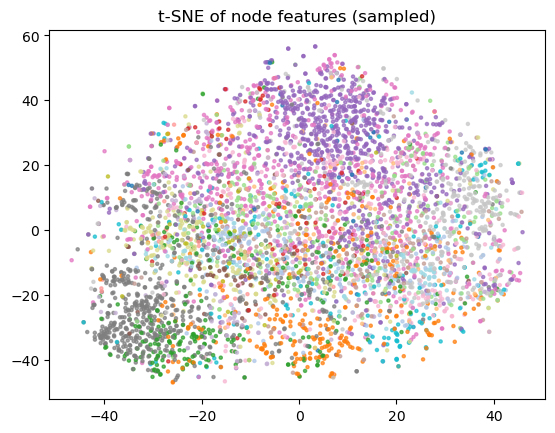

In [87]:
sample_size = 5000

X = node_feat.values
y = labels.label.values

idx = np.random.choice(X.shape[0], sample_size, replace=False)
X_sample = X[idx]
y_sample = y[idx]

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_2d = tsne.fit_transform(X_sample)

plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_sample, cmap="tab20", s=5, alpha=0.7)
plt.title("t-SNE of node features (sampled)")
plt.show()

In [92]:
# Example with UMAP
from umap import UMAP
import matplotlib.pyplot as plt

# Reduce to 2D
reducer = UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
embedding_2d = reducer.fit_transform(node_feat)

# Plot with category colors
plt.figure(figsize=(12, 8))
scatter = plt.scatter(embedding_2d[:, 0], embedding_2d[:, 1],
                     c=labels['label'], cmap='tab20', alpha=0.6, s=1)
plt.colorbar(scatter)
plt.title('2D Feature Visualization')

ImportError: cannot import name 'UMAP' from 'umap' (C:\Users\jhowert\AppData\Roaming\Python\Python313\site-packages\umap\__init__.py)

Total variance explained: 16.2%


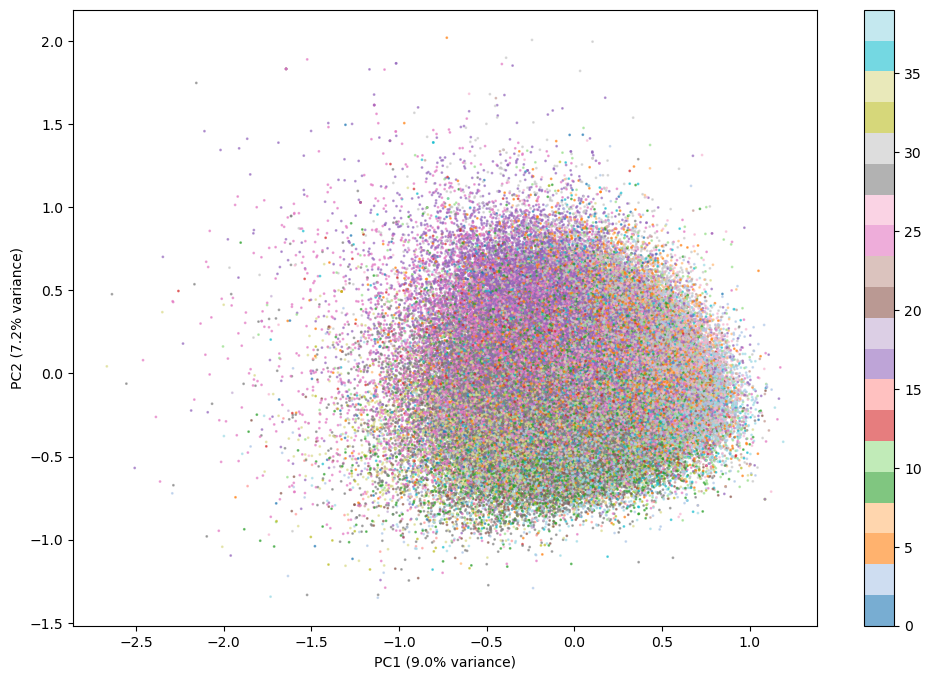

In [90]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Fit PCA
pca = PCA(n_components=2, random_state=42)
features_2d = pca.fit_transform(node_feat)

# Plot
plt.figure(figsize=(12, 8))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels['label'], cmap='tab20', alpha=0.6, s=1)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.colorbar(scatter)

print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.1%}")

## Edge Feature
Empty (Not Used)

In [34]:
edge_feat.shape

(0, 0)

## Edge Index
Edge Index contains the citation relationships between any two nodes/papers. The graph structure captures academic citation relationships through directed edges, where an edge from node A to node B indicates that paper A cites paper B [1].

In [25]:
edge_index.head()

,0,1,2,3,4,5,6,7,8,9,...,1166233,1166234,1166235,1166236,1166237,1166238,1166239,1166240,1166241,1166242
0,104447,15858,107156,107156,107156,107156,141536,141536,141536,141536,...,45118,45118,45118,45118,45118,45118,45118,45118,45118,45118
1,13091,47283,69161,136440,107366,158460,90124,121740,122427,161023,...,144525,49499,29457,144665,135414,79124,147994,162473,162537,72717


In [26]:
node_year.head()

,0
0,2013
1,2015
2,2014
3,2014
4,2014
